In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression,LogisticRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import entropy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import xgboost as xgb


from collections import Counter
from sklearn.metrics import roc_curve, auc,accuracy_score
import pickle
from sklearn.decomposition import PCA
from datetime import datetime


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Import Data

In [2]:
btc_min_return = pd.read_csv('btc_min_return_selected.csv')
btc_min_return.index =pd.to_datetime(btc_min_return['timestamp'])
btc_min_return.drop(columns=['timestamp'],inplace=True)
btc_min_return=btc_min_return[btc_min_return.index > '2019']
btc_min_return['return_scaled'] = btc_min_return['return']*100
print(btc_min_return.columns)

features = btc_min_return.columns.to_list()
features.remove('return')
features.remove('return_scaled')
features.remove('J_test_stats')
TI_features = features[:6]+features[-17:]
SV_features = features[:-17]
Naive_features = features[:6]

Index(['open', 'high', 'low', 'number_of_trades', 'close', 'return', 'volume',
       'jump_detected_1_3', 'jump_size_1_3', 'jump_detected_2_3',
       'jump_size_2_3', 'jump_detected_3_3', 'jump_size_3_3',
       'jump_detected_1_1', 'jump_size_1_1', 'jump_detected_2_1',
       'jump_size_2_1', 'RV_d', 'log1+J', 'sigma2_hat', 'shape_left',
       'scale_left', 'shape_right', 'scale_right', 'RS_neg', 'RS_pos', 'BPV',
       'RS', 'JP', 'J_test_stats', 'BPV_test_jump',
       'rolling_mean_return_15min', 'rolling_std_return_15min',
       'rolling_mean_volume_15min', 'rolling_std_volume_15min',
       'return_lag_1min', 'return_lag_5min', 'return_lag_10min',
       'return_lag_15min', 'return_volume_interaction', 'ema_return_5min',
       'hist_vol_5min', 'macd', 'macd_signal', 'rsi', 'bollinger_hband',
       'bollinger_lband', 'atr', 'return_scaled'],
      dtype='object')


### Generate Labels

In [3]:
quantile_upper = 0.66
quantile_lower = 1-quantile_upper
accuracy_metric = 'Build_in_acc'
target_used = 'target_quantile'

In [4]:
# Create the target variable -- Quantile based threshold
upper_quantile = btc_min_return['return_scaled'].quantile(quantile_upper)
lower_quantile = btc_min_return['return_scaled'].quantile(quantile_lower)
btc_min_return['target_quantile'] = 0
btc_min_return.loc[btc_min_return['return_scaled'].shift(-1) > upper_quantile, 'target_quantile'] = 1
btc_min_return.loc[btc_min_return['return_scaled'].shift(-1) < lower_quantile, 'target_quantile'] = -1
btc_min_return = btc_min_return.dropna()
print([upper_quantile,lower_quantile])

[0.019647143378991403, -0.0197879282974798]


In [5]:
df = btc_min_return.copy()
X = df[features]
y = df[target_used]

# Split the data into training and test sets
cutoff_date = '2022-01-01'
X_train = X[btc_min_return.index < cutoff_date]
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = X[btc_min_return.index >= cutoff_date]
scaler = StandardScaler()
X_test= scaler.fit_transform(X_test)
y_train = y[btc_min_return.index < cutoff_date]
y_test = y[btc_min_return.index >= cutoff_date]

In [6]:
X_TI = df[TI_features]
X_train_TI = X_TI[df[TI_features].index < cutoff_date]
scaler = StandardScaler()
X_train_TI= scaler.fit_transform(X_train_TI)
X_test_TI = X_TI[df[TI_features].index >= cutoff_date]
scaler = StandardScaler()
X_test_TI= scaler.fit_transform(X_test_TI)

X_SV = df[SV_features]
scaler = StandardScaler()
X_SV= scaler.fit_transform(X_SV)
X_train_SV = X_SV[df[SV_features].index < cutoff_date]
X_test_SV = X_SV[df[SV_features].index >= cutoff_date]

X_Naive = df[Naive_features]
scaler = StandardScaler()
X_Naive= scaler.fit_transform(X_Naive)
X_train_Naive = X_Naive[df[Naive_features].index < cutoff_date]
X_test_Naive = X_Naive[df[Naive_features].index >= cutoff_date]

### Evaluation Feaures' Prediction Powers

In [7]:
def compute_pearson_correlation(X, y, feature_name):
    corr = X.corrwith(y).abs().sort_values(ascending=False).round(3)
    return pd.DataFrame({
        'Feature': corr.index,
        f'Prediction Power (Pearson Correlation) {feature_name}': corr.values
    }).reset_index(drop=True)

def compute_rfe(X, y, feature_name):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=5)
    rfe = rfe.fit(X, y)
    rfe_ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values().round(3)
    return pd.DataFrame({
        'Feature': rfe_ranking.index,
        f'Prediction Power (Recursive Feature Elimination) {feature_name}': rfe_ranking.values
    }).reset_index(drop=True)

def compute_mutual_information(X, y, feature_name):
    mi = mutual_info_classif(X, y)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False).round(3)
    return pd.DataFrame({
        'Feature': mi_series.index,
        f'Prediction Power (Mutual Information) {feature_name}': mi_series.values
    }).reset_index(drop=True)

def compute_xgb_importances(X, y, feature_name):
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    xgb_model.fit(X, y_encoded)
    xgb_importances = xgb_model.feature_importances_
    xgb_feature_importances = pd.Series(xgb_importances, index=X.columns).sort_values(ascending=False).round(3)
    return pd.DataFrame({
        'Feature': xgb_feature_importances.index,
        f'Prediction Power (XGBoost Feature Importances) {feature_name}': xgb_feature_importances.values
    }).reset_index(drop=True)

def combine_feature_importance_tables(corr_table, rfe_table, mi_table, xgb_table):
    combined_df = corr_table.merge(
        rfe_table, on='Feature', how='left'
    ).merge(
        mi_table, on='Feature', how='left'
    ).merge(
        xgb_table, on='Feature', how='left'
    )
    return combined_df



In [93]:
def apply_styling(data):
    return data.style.apply(
        lambda x: highlight_top_features(x, top_n=6, ascending=False, colors=colors) if x.name == rfe_col
                  else highlight_top_features(x, top_n=6, ascending=True, colors=colors), 
        axis=0
    )

def highlight_top_features(s, top_n, ascending=True, colors=None):
    if colors is None:
        colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightpink', 'lightgoldenrodyellow']
    
    # Determine the top features based on the sorting order
    top_features = s.nlargest(top_n) if ascending else s.nsmallest(top_n)
    color_map = {feature: colors[i % len(colors)] for i, feature in enumerate(top_features.index)}
    
    return [f'background-color: {color_map.get(x, "lightgray")}; color: black;' for x in s.index]

def highlight_features_df(df, top_n=6):
    # Define the colors
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightpink', 'lightgoldenrodyellow']
    
    # Get the feature name suffix
    feature_name_suffix = df.columns[1].split(' ')[-1].strip() if df.columns.size > 0 else ''

    # Create column name templates
    corr_col = f'Prediction Power (Pearson Correlation) {feature_name_suffix}'
    rfe_col = f'Prediction Power (Recursive Feature Elimination) {feature_name_suffix}'
    mi_col = f'Prediction Power (Mutual Information) {feature_name_suffix}'
    xgb_col = f'Prediction Power (XGBoost Feature Importances) {feature_name_suffix}'

    # Create a DataFrame with 'Pearson Correlation' first and others following
    combined_df = pd.concat([
        df[['Feature', corr_col]],  # Ensure Pearson Correlation is first
        df[[ xgb_col,mi_col]],  # Include Mutual Information and XGBoost Importances
        df[[rfe_col]]  # Include Recursive Feature Elimination
    ], axis=1)
    
    # Set 'Feature' as the index before applying styling
    combined_df.set_index('Feature', inplace=True)

    return apply_styling(combined_df)


In [92]:
# Extract suffix for column names
feature_name_suffix = pred_power_SV.columns[1].split(' ')[-1].strip()
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightpink', 'lightgoldenrodyellow']
corr_col = f'Prediction Power (Pearson Correlation) {feature_name_suffix}'
rfe_col = f'Prediction Power (Recursive Feature Elimination) {feature_name_suffix}'
mi_col = f'Prediction Power (Mutual Information) {feature_name_suffix}'
xgb_col = f'Prediction Power (XGBoost Feature Importances) {feature_name_suffix}'

# Create a DataFrame with 'Pearson Correlation' first and others following
combined_df = pd.concat([
    pred_power_SV[['Feature', corr_col]],  # Ensure Pearson Correlation is first
    pred_power_SV[[ xgb_col,mi_col]],  # Include Mutual Information and XGBoost Importances
    pred_power_SV[[rfe_col]]  # Include Recursive Feature Elimination
], axis=1)

# Set 'Feature' as the index before applying styling
combined_df.set_index('Feature', inplace=True)

# Apply different styling rules
def apply_styling(df):
    return df.style.apply(
        lambda x: highlight_top_features(x, top_n=6, ascending=False, colors=colors) if x.name == rfe_col
                  else highlight_top_features(x, top_n=6, ascending=True, colors=colors), 
        axis=0
    )

# Apply styling and display the DataFrame
styled_df = apply_styling(combined_df)
styled_df



,Prediction Power (Pearson Correlation) SV,Prediction Power (XGBoost Feature Importances) SV,Prediction Power (Mutual Information) SV,Prediction Power (Recursive Feature Elimination) SV
Feature,,,,
jump_size_1_3,0.047000,0.047000,0.002000,1
jump_size_1_1,0.046000,0.044000,0.002000,4
RS,0.032000,0.024000,0.031000,1
BPV_test_jump,0.017000,0.004000,0.029000,14
JP,0.010000,0.034000,0.033000,2
jump_size_2_3,0.008000,0.011000,0.000000,3
jump_size_2_1,0.008000,0.015000,0.000000,6
jump_size_3_3,0.004000,0.005000,0.001000,5
jump_detected_2_3,0.003000,0.010000,0.000000,12


In [94]:
def print_feature_importance(X, y, sub_features, features, feature_name):
    feature_subset = [item for item in sub_features if item not in features[:6]]
    X_subset = X[feature_subset]
    
    # Compute importances
    corr_table = compute_pearson_correlation(X_subset, y, feature_name)
    rfe_table = compute_rfe(X_subset, y, feature_name)
    mi_table = compute_mutual_information(X_subset, y, feature_name)
    xgb_table = compute_xgb_importances(X_subset, y, feature_name)
    
    # Combine DataFrames
    combined_df = combine_feature_importance_tables(corr_table, rfe_table, mi_table, xgb_table)
    
    # Highlight features
    styled_df = highlight_features_df(combined_df, top_n=6)
    
    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(9, 10))
    axs = axs.flatten()  # Flatten the array of axes

    # Plot Pearson Correlation
    axs[0].barh(corr_table['Feature'], corr_table[f'Prediction Power (Pearson Correlation) {feature_name}'], color='skyblue')
    axs[0].set_title(f'Prediction Power (Pearson Correlation) {feature_name}')
    axs[0].set_xlabel('Correlation')
    axs[0].invert_yaxis()

    # Plot RFE Ranking
    axs[1].barh(rfe_table['Feature'], rfe_table[f'Prediction Power (Recursive Feature Elimination) {feature_name}'], color='salmon')
    axs[1].set_title(f'Prediction Power (Recursive Feature Elimination) {feature_name}')
    axs[1].set_xlabel('Ranking')
    axs[1].invert_yaxis()

    # Plot Mutual Information
    axs[2].barh(mi_table['Feature'], mi_table[f'Prediction Power (Mutual Information) {feature_name}'], color='lightgreen')
    axs[2].set_title(f'Prediction Power (Mutual Information) {feature_name}')
    axs[2].set_xlabel('Mutual Information')
    axs[2].invert_yaxis()

    # Plot XGBoost Feature Importances
    axs[3].barh(xgb_table['Feature'], xgb_table[f'Prediction Power (XGBoost Feature Importances) {feature_name}'], color='orange')
    axs[3].set_title(f'Prediction Power (XGBoost Feature Importances) {feature_name}')
    axs[3].set_xlabel('Importance')
    axs[3].invert_yaxis()

    plt.tight_layout()
    plt.show()

    return combined_df



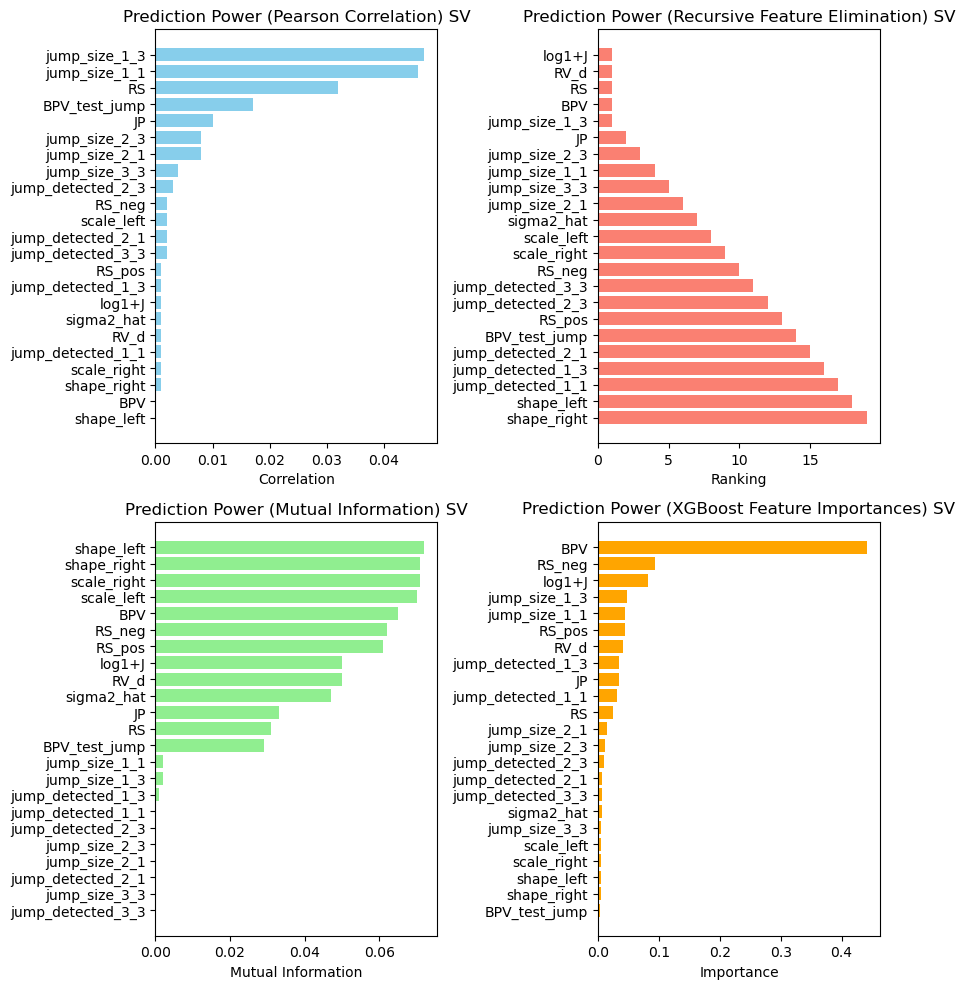

,Feature,Prediction Power (Pearson Correlation) SV,Prediction Power (Recursive Feature Elimination) SV,Prediction Power (Mutual Information) SV,Prediction Power (XGBoost Feature Importances) SV
0,jump_size_1_3,0.047,1,0.002,0.047
1,jump_size_1_1,0.046,4,0.002,0.044
2,RS,0.032,1,0.031,0.024
3,BPV_test_jump,0.017,14,0.029,0.004
4,JP,0.010,2,0.033,0.034
5,jump_size_2_3,0.008,3,0.000,0.011
6,jump_size_2_1,0.008,6,0.000,0.015
7,jump_size_3_3,0.004,5,0.000,0.005
8,jump_detected_2_3,0.003,12,0.000,0.010
9,RS_neg,0.002,10,0.062,0.093


In [95]:
pred_power_SV = print_feature_importance(X, y, SV_features, features,'SV')
pred_power_SV

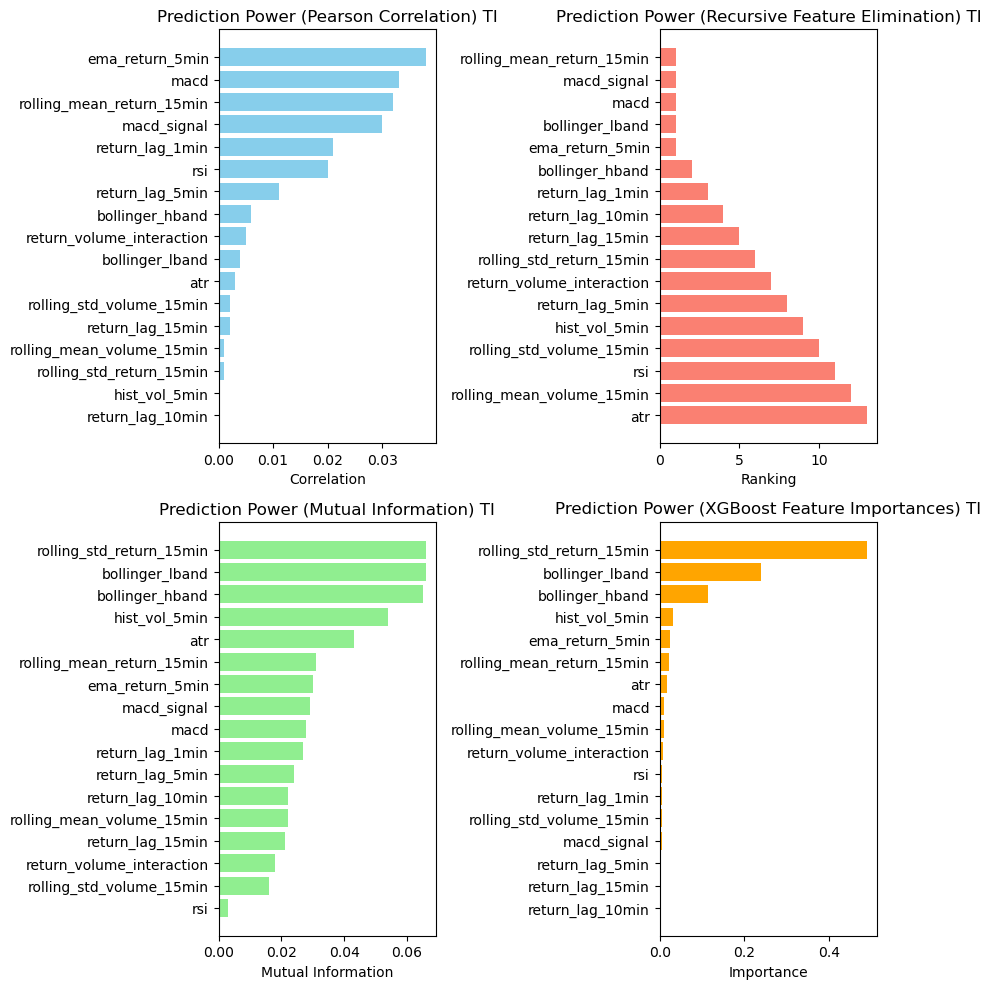

,Feature,Prediction Power (Pearson Correlation) TI,Prediction Power (Recursive Feature Elimination) TI,Prediction Power (Mutual Information) TI,Prediction Power (XGBoost Feature Importances) TI
0,ema_return_5min,0.038,1,0.030,0.025
1,macd,0.033,1,0.028,0.010
2,rolling_mean_return_15min,0.032,1,0.031,0.022
3,macd_signal,0.030,1,0.029,0.005
4,return_lag_1min,0.021,3,0.027,0.006
5,rsi,0.020,11,0.003,0.006
6,return_lag_5min,0.011,8,0.024,0.004
7,bollinger_hband,0.006,2,0.065,0.114
8,return_volume_interaction,0.005,7,0.018,0.008
9,bollinger_lband,0.004,1,0.066,0.239


In [96]:
pred_power_TI=print_feature_importance(X, y, TI_features, features,'TI')
pred_power_TI

### Benchmark Model Performance

In [ ]:
def custom_accuracy(y_true, y_pred):
    Accuracy = {}
    
    # Acc_Ignore_Pred_Neutral: Accuracy when ignoring neutral predictions
    mask_pred_non_neutral = y_pred != 0
    correct_pred_non_neutral = (y_true[mask_pred_non_neutral] == y_pred[mask_pred_non_neutral]).sum()
    total_pred_non_neutral = mask_pred_non_neutral.sum()
    Accuracy['Acc_Ignore_Pred_Neutral'] = (
        correct_pred_non_neutral / total_pred_non_neutral 
        if total_pred_non_neutral > 0 
        else 0
    )
    
    # Acc_Ignore_True_Neutral: Accuracy when ignoring neutral true labels
    mask_true_non_neutral = y_true != 0
    correct_true_non_neutral = (y_true[mask_true_non_neutral] == y_pred[mask_true_non_neutral]).sum()
    total_true_non_neutral = mask_true_non_neutral.sum()
    Accuracy['Acc_Ignore_True_Neutral'] = (
        correct_true_non_neutral / total_true_non_neutral 
        if total_true_non_neutral > 0 
        else 0
    )
    
    # Acc_True: Standard accuracy
    Accuracy['Acc_True'] = accuracy_score(y_true, y_pred)
    
    # Round the accuracy values to 2 decimal places
    Acc = {k: round(v, 2) for k, v in Accuracy.items()}
    
    # Return the accuracies as a DataFrame
    return pd.DataFrame([Acc])


In [ ]:
# Custom accuracy calculation
def custom_accuracy(y_true, y_pred):
    # Accuracy ignoring predicted neutral (0) labels
    Acc_Ignore_Pred_Neutral = (
        (y_pred[(y_pred != 0) & (y_true == y_pred)]).size /
        (y_pred != 0).sum()
    )
    
    # Accuracy ignoring true neutral (0) labels
    Acc_Ignore_True_Neutral = (
        (y_pred[(y_true != 0) & (y_true == y_pred)]).size /
        (y_true != 0).sum()
    )
    
    # Standard accuracy
    Acc_True = accuracy_score(y_true, y_pred)

    # Return results in DataFrame
    accuracy_results = {
        'Acc_Ignore_Pred_Neutral': round(Acc_Ignore_Pred_Neutral, 2),
        'Acc_Ignore_True_Neutral': round(Acc_Ignore_True_Neutral, 2),
        'Acc_True': round(Acc_True, 2)
    }
    return pd.DataFrame([accuracy_results])

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, model_name, ax):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name} - Confusion Matrix')

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob, class_names, model_name, ax):
    y_true_bin = label_binarize(y_true, classes=[-1, 0, 1])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i, class_label in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_prob[:, i])

    for i, class_label in enumerate(class_names):
        ax.plot(fpr[i], tpr[i], label=f'Class {class_names[class_label]} (area = {roc_auc[i]:0.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - ROC Curve')
    ax.legend(loc="lower right")

def create_trade_summary(results, models):
    summary_data = []

    # Iterate over models to calculate trade summary
    for model in models:
        y_pred_class = results[model]['0']['y_pred_class']

        # Count occurrences of each class
        count = Counter(y_pred_class)
        
        # Calculate positive, negative, and no-action counts
        pos_trade_count = count.get(1, 0)  # Positive trades count
        neg_trade_count = count.get(-1, 0)  # Negative trades count (if -1 is in the labels)
        no_action_count = count.get(0, 0)  # No-action count (if 0 is in the labels)
        
        # Total transactions including no-action counts
        total_transac = pos_trade_count + neg_trade_count
        
        # Calculate percentages
        pos_trade_ptc = f"{(pos_trade_count / total_transac * 100):.0f}%" if total_transac > 0 else "0.00%"
        neg_trade_ptc = f"{(neg_trade_count / total_transac * 100):.0f}%" if total_transac > 0 else "0.00%"
            
        # Append to row_data for the current model
        summary_data.append({
            'Model': model,
            'Pos_trade_ptc': pos_trade_ptc,
            'Neg_trade_ptc': neg_trade_ptc,
            'Total_transac': total_transac
        })

    # Create DataFrame
    summary_df = pd.DataFrame(summary_data)
    summary_df.set_index('Model', inplace=True)
    
    return summary_df


# Function to train and evaluate a single model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model, model_name, n=None):
    if n is not None and model_name != 'Naive':  # Apply PCA only if n is specified and model is not Naive
        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    else:
        X_train_pca, X_test_pca = X_train, X_test

    model.fit(X_train_pca, y_train)

    # Predict discrete labels
    y_pred = model.predict(X_test_pca)

    # Compute custom accuracy
    custom_acc = custom_accuracy(y_test, y_pred)

    # Prepare trade summary data
    trade_summary = {
        'y_pred_class': y_pred
    }

    return y_pred, model.predict_proba(X_test_pca), custom_acc, trade_summary

# Wrapper function to handle multiple models
def evaluate_multiple_models(X_train_list, X_test_list, y_train, y_test, model, model_names, n=None):
    accuracies = {}
    trade_summaries = {}
    results = {model_name: {'0': {}} for model_name in model_names}

    # Create subplots for confusion matrices and ROC curves
    fig_cm, axs_cm = plt.subplots(1, len(model_names), figsize=(9, 3))
    fig_roc, axs_roc = plt.subplots(1, len(model_names), figsize=(9, 3))

    for i, (X_train, X_test, model_name) in enumerate(zip(X_train_list, X_test_list, model_names)):
        y_pred, y_pred_prob, custom_acc, trade_summary = train_and_evaluate_model(X_train, y_train, X_test, y_test, model, model_name, n)

        # Store accuracies
        accuracies[model_name] = custom_acc.squeeze()  # Convert DataFrame to Series
        
        # Store trade summaries
        trade_summaries[model_name] = trade_summary
        
        # Store results for trade summary calculation
        results[model_name]['0'] = {'y_pred_class': y_pred}

        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, ['Negative', 'Neutral', 'Positive'], model_name, axs_cm[i])
        
        # Plot ROC curve
        plot_roc_curve(y_test, y_pred_prob, {-1: 0, 0: 1, 1: 2}, model_name, axs_roc[i])

    # Display plots
    fig_cm.tight_layout()
    fig_roc.tight_layout()
    plt.show()

    # Create DataFrame for accuracies
    accuracy_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Acc_Ignore_Pred_Neutral', 'Acc_Ignore_True_Neutral', 'Acc_True'])
    
    # Create trade summary DataFrame
    trade_summary_df = create_trade_summary(results, model_names)

    return accuracy_df, trade_summary_df


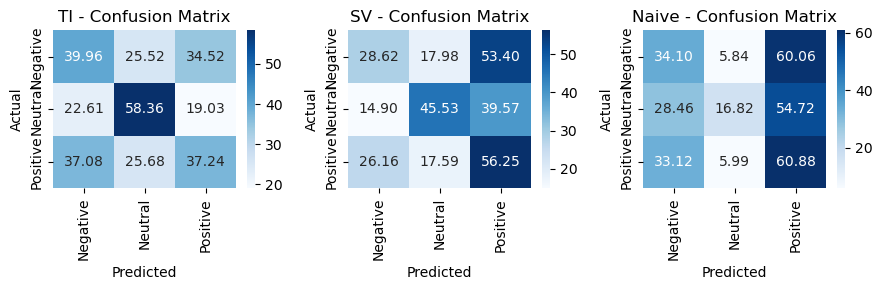

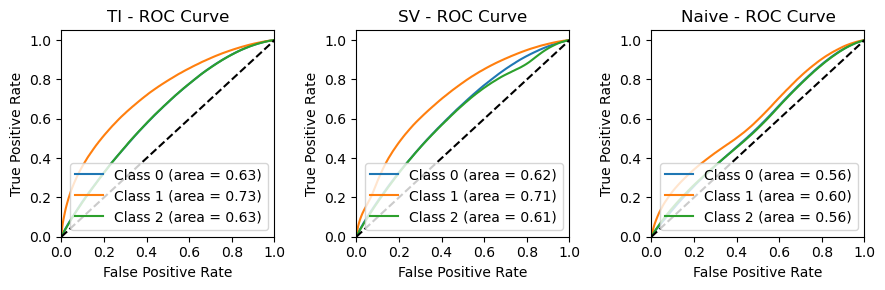

In [ ]:
X_train_list = [X_train_TI, X_train_SV, X_train_Naive]
X_test_list = [X_test_TI, X_test_SV, X_test_Naive]
model_names = ['TI', 'SV', 'Naive']

model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')

accuracy_df, trade_summary_df = evaluate_multiple_models(X_train_list, X_test_list, y_train, y_test, model, model_names, n=15)


In [ ]:
accuracy_df

,Acc_Ignore_Pred_Neutral,Acc_Ignore_True_Neutral,Acc_True
TI,0.38,0.39,0.46
SV,0.37,0.42,0.44
Naive,0.33,0.47,0.36


In [ ]:
trade_summary_df

,Pos_trade_ptc,Neg_trade_ptc,Total_transac
Model,,,
TI,48%,52%,513958
SV,68%,32%,594988
Naive,65%,35%,747480
